From: https://mapr.com/blog/deep-learning-tensorflow/

In [1]:
import sys
sys.version

'3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) \n[GCC 7.3.0]'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [3]:
tf.__version__

'1.11.0'

,Time,Low,High,Open,Close,Volume,CloseDelta,CloseDeltaNorm,VolumeDelta,VolumeDeltaNorm,RollingMean,Predictions
120291,2018-02-06 03:25:00,6210.00,6317.35,6299.98,6211.15,427.946005,-0.014098,-0.134020,-0.475875,-0.000835,6689.182708,-1.655968
120290,2018-02-06 03:30:00,6200.00,6213.00,6211.14,6200.01,315.910305,-0.001794,-0.017047,-0.261799,-0.000690,6689.703542,-1.620776
120289,2018-02-06 03:35:00,6180.00,6273.00,6200.00,6180.01,492.743655,-0.003226,-0.030662,0.559758,-0.000134,6690.227882,-1.582734
120288,2018-02-06 03:40:00,6180.00,6237.46,6180.00,6198.91,250.516005,0.003058,0.029075,-0.491590,-0.000845,6690.087917,-1.545035
120287,2018-02-06 03:45:00,6181.26,6271.52,6198.91,6271.52,340.261457,0.011713,0.111353,0.358242,-0.000270,6689.438576,-1.507364


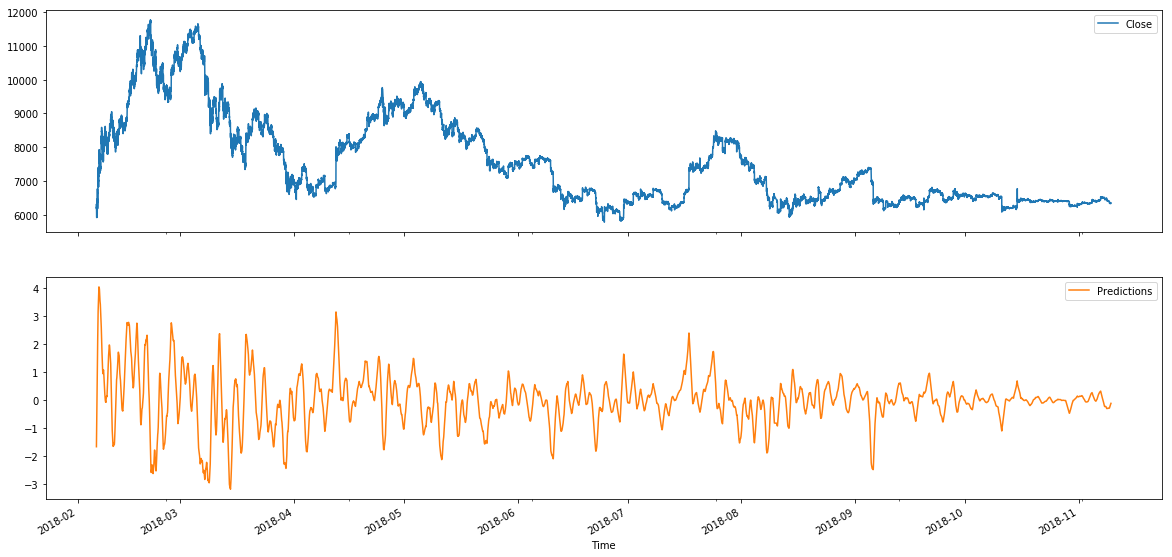

In [117]:
window = 288 # 1 day

file_name = './historic_data/BTC-USD_300_200173.csv'
df = pd.read_csv(file_name, index_col='Time', parse_dates=True, infer_datetime_format=True)
df['Time']=pd.to_datetime(df['Time'])
df.sort_values('Time', ascending=True, inplace=True)
df.drop_duplicates(subset='Time', inplace=True)
df = df.iloc[-80000:]

df['CloseDelta'] = df['Close'].pct_change()
df['CloseDeltaNorm'] = (df['CloseDelta'] - df['CloseDelta'].mean()) / (df['CloseDelta'].max() - df['CloseDelta'].min())
df['VolumeDelta'] = df['Volume'].pct_change()
df['VolumeDeltaNorm'] = (df['VolumeDelta'] - df['VolumeDelta'].mean()) / (df['VolumeDelta'].max() - df['VolumeDelta'].min())

df['RollingMean'] = df['Close'].rolling(window=window,center=True).mean()
df['Predictions'] = pd.Series(df['RollingMean'].diff().rolling(window=window,center=True).mean())
df.dropna(inplace=True)

df.plot(x='Time', y=['Close', 'Predictions'], subplots=True, figsize=(20,10))
df.head()


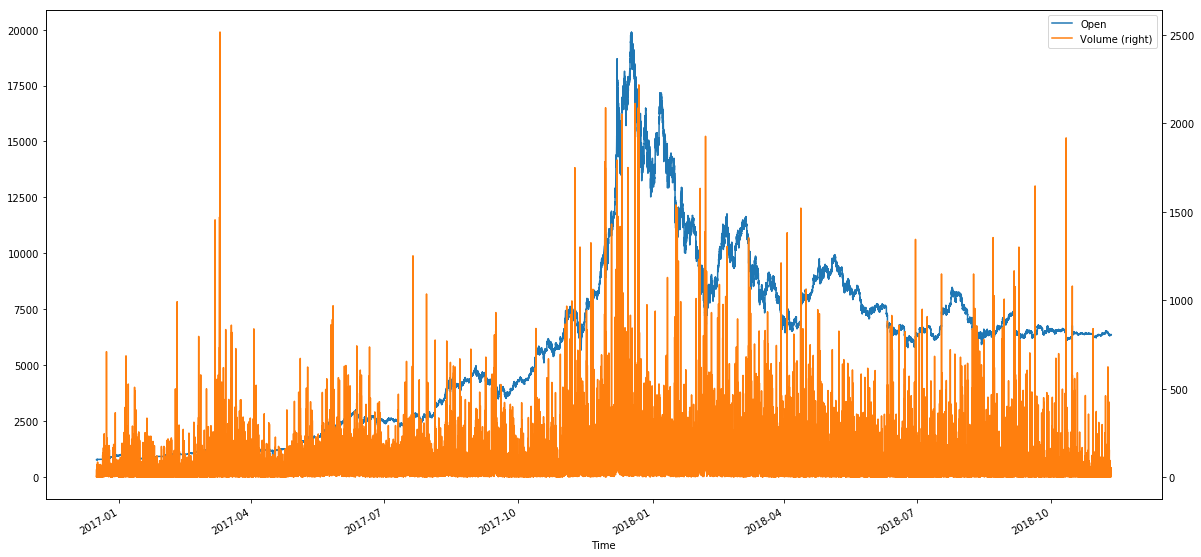

In [196]:
window = 288 # 1 day

file_name = './historic_data/BTC-USD_300_200173.csv'
df = pd.read_csv(file_name, index_col='Time', parse_dates=True, infer_datetime_format=True).sort_index()
#df[~df.index.duplicated(keep='first')] # Drop duplicates in index
#df.resample('1Min').max().reset_index().groupby('Time').sum()
#df.resample('1Min').max().reset_index()
conversion = {'Open' : 'first', 'High' : 'max', 'Low' : 'min', 'Close' : 'last', 'Volume' : 'sum'}
df.resample('1Min').apply(conversion)
#fig, ax = plt.subplots()
df.plot(y=['Open', 'Volume'], secondary_y=['Volume'], figsize=(20, 10))

#df.head()
#df['Time']


In [164]:
df.index

DatetimeIndex(['2016-12-17 10:00:00', '2016-12-17 09:55:00',
               '2016-12-17 09:50:00', '2016-12-17 09:45:00',
               '2016-12-17 09:40:00', '2016-12-17 09:35:00',
               '2016-12-17 09:30:00', '2016-12-17 09:25:00',
               '2016-12-17 09:20:00', '2016-12-17 09:15:00',
               ...
               '2018-11-09 15:25:00', '2018-11-09 15:20:00',
               '2018-11-09 15:15:00', '2018-11-09 15:10:00',
               '2018-11-09 15:05:00', '2018-11-09 15:00:00',
               '2018-11-09 14:55:00', '2018-11-09 14:50:00',
               '2018-11-09 14:45:00', '2018-11-09 14:40:00'],
              dtype='datetime64[ns]', name='Time', length=200173, freq=None)

In [119]:
X1=np.array(df['CloseDeltaNorm'])
X2=np.array(df['VolumeDeltaNorm'])

Y=np.array(df['Predictions'])

sequence_length = 288 * 7 # One Week
test_periods = 4

x1_data = X1[:(len(X1) - test_periods * sequence_length - (len(X1) % sequence_length))]
x2_data = X2[:(len(X2) - test_periods * sequence_length - (len(X2) % sequence_length))]
x_data = np.dstack([x1_data, x2_data])

x_batches = x_data.reshape(-1, sequence_length, 2)

y_data = Y[:(len(Y) - test_periods * sequence_length - (len(Y) % sequence_length))]
y_batches = y_data.reshape(-1, sequence_length, 1)

print(x_batches.shape)
print(y_batches.shape)

(35, 2016, 2)
(35, 2016, 1)


In [120]:
testX1 = X1[-(test_periods*sequence_length):]
testX2 = X2[-(test_periods*sequence_length):]
testX = np.dstack([testX1, testX2]).reshape(-1, sequence_length, 2)
testY = Y[-(test_periods*sequence_length):].reshape(-1, sequence_length, 1)
print(testX.shape)
print(testY.shape)

(4, 2016, 2)
(4, 2016, 1)


In [158]:
tf.reset_default_graph()

input_s = 2
hidden = 512
output_s = 1
learning_rate = 0.001

x = tf.placeholder(tf.float32, [None, sequence_length, input_s])
y = tf.placeholder(tf.float32, [None, sequence_length, output_s])

basic_cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)
rnn_output = tf.reshape(rnn_output, [-1, hidden])
outputs = tf.layers.dense(rnn_output, output_s)
outputs = tf.reshape(outputs, [-1, sequence_length, output_s])

loss = tf.losses.mean_squared_error(y, outputs)
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimiser.minimize(loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [159]:
epochs = 1000

checkpoint_path = "/home/richie/repo/twisty/dev/notebooks/cpts/512u80000p.ckpt"
continue_training = True

with tf.Session() as sess:
    init.run()
    if continue_training and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
        print("Model {} restored.".format(checkpoint_path))
    for ep in range(epochs):
        _, train_loss = sess.run((training_op, loss), feed_dict={x: x_batches, y: y_batches})
        if ep % 10 == 0:
            mse = loss.eval(feed_dict={x: testX, y: testY})
            print("{}\tTrain Loss: {}\tTest Loss: {}".format(ep, train_loss * 4, mse * 35))
            save_path = saver.save(sess, checkpoint_path)
            
    # Save the variables to disk.
    save_path = saver.save(sess, checkpoint_path)
    print("Model saved in path: %s" % save_path)

0	Train Loss: 3.3476450443267822	Test Loss: 1.0983074828982353
10	Train Loss: 3.346003293991089	Test Loss: 1.0203543026000261
20	Train Loss: 3.345609664916992	Test Loss: 1.015229970216751
30	Train Loss: 3.3428962230682373	Test Loss: 1.0118812881410122
40	Train Loss: 3.339906692504883	Test Loss: 1.0140269063413143
50	Train Loss: 3.3370018005371094	Test Loss: 1.0241921246051788
60	Train Loss: 3.334050416946411	Test Loss: 1.0414612479507923
70	Train Loss: 3.3296022415161133	Test Loss: 1.0557272098958492
80	Train Loss: 3.3141226768493652	Test Loss: 1.13077312707901
90	Train Loss: 3.344961643218994	Test Loss: 1.0277240630239248
100	Train Loss: 3.3438217639923096	Test Loss: 1.0181543789803982
110	Train Loss: 3.3407859802246094	Test Loss: 1.0117664188146591
120	Train Loss: 3.337954044342041	Test Loss: 1.0105076152831316
130	Train Loss: 3.335476875305176	Test Loss: 1.0129957552999258
140	Train Loss: 3.3332431316375732	Test Loss: 1.0175424814224243
150	Train Loss: 3.331048011779785	Test Loss: 1

In [160]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, checkpoint_path)
    mse = loss.eval(feed_dict={x: testX, y: testY})
    print("Model restored. MSE:", mse)
    #ytrained = sess.run(outputs, feed_dict={x: x_batches})
    ypred = sess.run(outputs, feed_dict={x: testX})
    

INFO:tensorflow:Restoring parameters from /home/richie/repo/twisty/dev/notebooks/cpts/512u80000p.ckpt
Model restored. MSE: 0.029244956


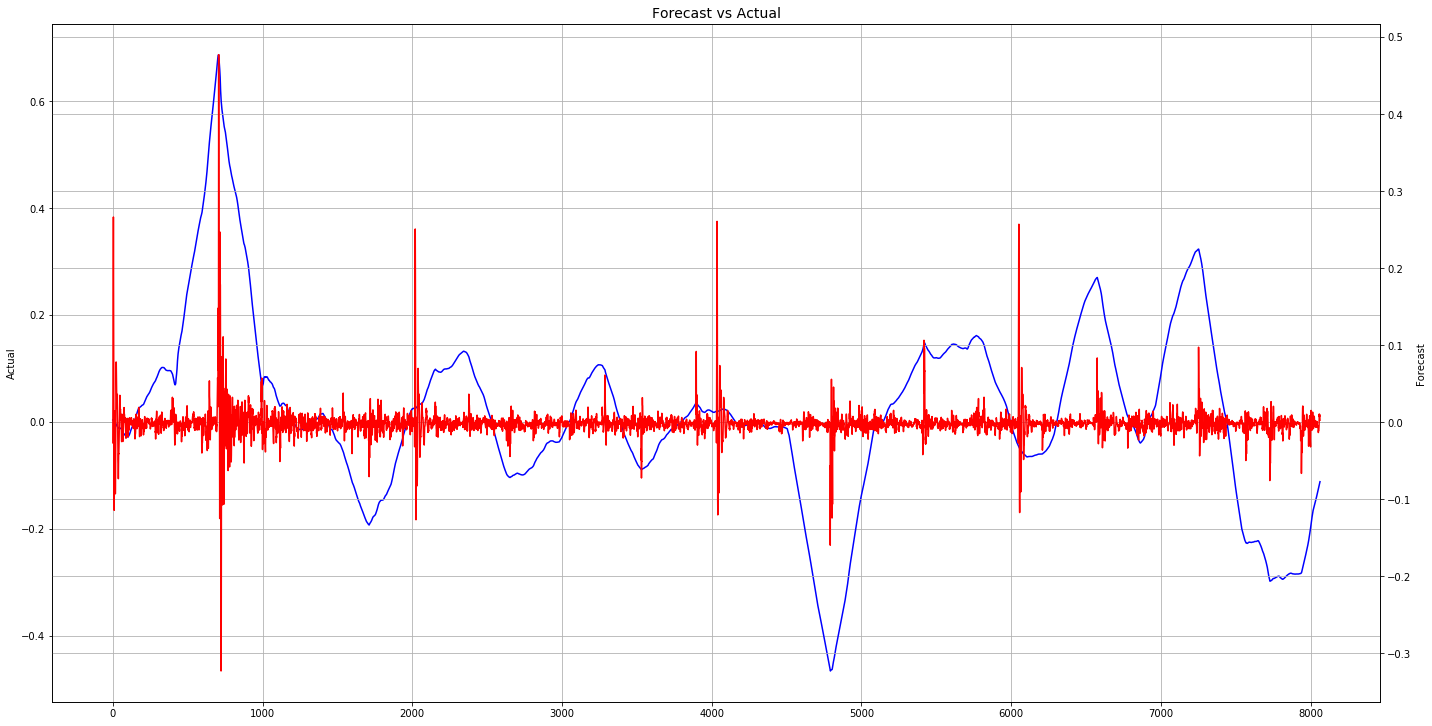

In [161]:
#https://matplotlib.org/examples/api/two_scales.html
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(pd.Series(np.ravel(testY)), 'b-')
ax1.set_ylabel("Actual")
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(pd.Series(np.ravel(ypred)), 'r-')
ax2.set_ylabel("Forecast")

fig.tight_layout()
plt.title("Forecast vs Actual", fontsize=14)
#plt.legend(loc="upper right")
plt.xlabel("Time")
plt.grid()

plt.show()

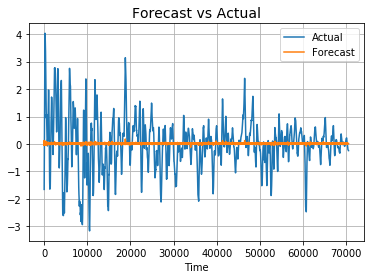

In [162]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_batches)), label="Actual")
plt.plot(pd.Series(np.ravel(ytrained)), label="Forecast")
plt.legend(loc="upper right")
plt.xlabel("Time")
plt.grid()

plt.show()